<a href="https://colab.research.google.com/github/lifesboy/selks-lstm-data/blob/main/SELKS_LSTM_Anomaly_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1.LSTM KERAS

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

# 2.PREPARATION

In [1]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-02-12 17:01:35.276718: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 17:01:37.537040: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-12 17:01:37.538224: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-12 17:01:37.539724: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [2]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pyarrow
import pyarrow as pa
from pyarrow import csv
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from numpy import array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras import Input


import common
from anomaly_normalization import PS, LABEL, PAYLOAD_FEATURE_NUM, ALL_FEATURES
from aimodels.preprocessing.cicflowmeter_norm_model import CicFlowmeterNormModel
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, show_train_metric, IMG,\
read_csv_in_dir, read_csv_in_dir_label_string

run, client = common.init_experiment(name='notebook')


2023-02-12 17:01:40,734[INFO][140229732415296-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 192.168.2.236:6379
[2023-02-12 17:01:40,857 I 27064 27064] global_state_accessor.cc:357: This node has an IP address of 172.18.12.180, while we can not found the matched Raylet address. This maybe come from when you connect the Ray cluster with a different IP address or connect a container.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [3]:
#@title Generate an input sequence
#10.0.2.10
#10.0.2.155
#10.0.2.180
#10.0.2.181
#10.0.2.182
#192.168.66.39
#192.168.66.21

cell_size = 320 #@param {type:"integer"} #numberOfLSTMunits
hidden_size = 230 #@param {type:"integer"}
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

# generate datasets
train_size= 40 #@param {type:"integer"}
test_size = 10  #@param {type:"integer"}
batch_size=32 #@param {type:"integer"}
epochs=100 #@param {type:"integer"}

L_source = '/cic/dataset/normalized_labeled/nsm-huongssh-v2ok-label/' #@param {type:"string"}
L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
#features = [*features, *[PS % i for i in range(0, PAYLOAD_FEATURE_NUM)]]
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()'])
predict_size = total_size // n_timesteps_in
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

2023-02-12 17:01:42,994	WARNING read_api.py:256 -- The number of blocks in this dataset (9) limits its parallelism to 9 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00,  3.11it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [4]:
L_count

label  count()
0    0.0     3341
1    1.0     2789

## Data preview

### L_train preview

In [5]:
L_predict[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0       0.0           0.0         0.0          0.0         0.0         0.0   
1       0.0           0.0         0.0          0.0         0.0         0.0   
2       0.0           0.0         0.0          0.0         0.0         0.0   
3       0.0           0.0         0.0          0.0         0.0         0.0   
4       0.0           0.0         0.0          0.0         0.0         0.0   
...     ...           ...         ...          ...         ...         ...   
6095    1.0           0.0         0.0          0.0         0.0         0.0   
6096    1.0           0.0         0.0          0.0         0.0         0.0   
6097    0.0           0.0         0.0          0.0         0.0         0.0   
6098    0.0           0.0         0.0          0.0         0.0         0.0   
6099    0.0           0.0         0.0          0.0         0.0         0.0   

      bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                  1.0             1.0             1.0          1.0   
1                  1.0             1.0             1.0          1.0   
2                  1.0             1.0             1.0          1.0   
3                  1.0             1.0             1.0          1.0   
4                  0.0             0.0             1.0          1.0   
...                ...             ...             ...          ...   
6095               0.0             0.0             1.0          1.0   
6096               0.0             0.0             1.0          1.0   
6097               0.0             0.0             0.0          0.0   
6098               0.0             0.0             0.0          0.0   
6099               0.0             0.0             1.0          0.0   

      bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0              1.0    -1.000000          1.0          1.0              1.0   
1              1.0     0.995055          1.0          1.0              1.0   
2              1.0     0.999329          1.0          1.0              1.0   
3              1.0     0.999909          1.0          1.0              1.0   
4              1.0     1.000000          1.0          1.0              1.0   
...            ...          ...          ...          ...              ...   
6095           1.0     1.000000          1.0          1.0              1.0   
6096           1.0     1.000000          1.0          1.0              1.0   
6097           0.0     0.000000          0.0          0.0              0.0   
6098           0.0     0.000000          0.0          0.0              0.0   
6099           0.0     0.000000          0.0          0.0              1.0   

      bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                  1.0              1.0              1.0        0.999329   
1                  1.0              1.0              1.0        0.999329   
2                  1.0              1.0              1.0        0.999329   
3                  1.0              1.0              1.0        0.999329   
4                  1.0              1.0              1.0        0.000000   
...                ...              ...              ...             ...   
6095               1.0              1.0              1.0        0.000000   
6096               1.0              1.0              1.0        0.000000   
6097               0.0              0.0              0.0        0.000000   
6098               0.0              0.0              0.0        0.000000   
6099               1.0              1.0              0.0        0.000000   

      bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0       0.992288            0.0               1.0            0.0   
1       1.000000            0.0               1.0            0.0   
2       0.999858            0.0               1.0            0.0   
3       0.999864            0.0               1.0            0.0   
4       0.999705          

In [6]:
L_predict[[LABEL, *features]].describe()

label  ack_flag_cnt   active_max  active_mean   active_min  \
count  6100.000000        6100.0  6100.000000  6100.000000  6100.000000   
mean      0.457213           0.0     0.081311     0.081311     0.081311   
std       0.498207           0.0     0.273335     0.273335     0.273335   
min       0.000000           0.0     0.000000     0.000000     0.000000   
25%       0.000000           0.0     0.000000     0.000000     0.000000   
50%       0.000000           0.0     0.000000     0.000000     0.000000   
75%       1.000000           0.0     0.000000     0.000000     0.000000   
max       1.000000           0.0     1.000000     1.000000     1.000000   

        active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count  6100.000000       6100.000000     6100.000000     6100.000000   
mean      0.081311          0.243934        0.243934        0.869836   
std       0.273335          0.429489        0.429489        0.336511   
min       0.000000          0.000000        0.000000        0.000000   
25%       0.000000          0.000000        0.000000        1.000000   
50%       0.000000          0.000000        0.000000        1.000000   
75%       0.000000          0.000000        0.000000        1.000000   
max       1.000000          1.000000        1.000000        1.000000   

       bwd_iat_max  bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  \
count  6100.000000   6100.000000  6100.000000  6100.000000  6100.000000   
mean      0.786721      0.786721     0.691238     0.786721     0.786721   
std       0.409656      0.409656     0.551597     0.409656     0.409656   
min       0.000000      0.000000    -1.000000     0.000000     0.000000   
25%       1.000000      1.000000     0.000000     1.000000     1.000000   
50%       1.000000      1.000000     1.000000     1.000000     1.000000   
75%       1.000000      1.000000     1.000000     1.000000     1.000000   
max       1.000000      1.000000     1.000000     1.000000     1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count      6100.000000       6100.000000      6100.000000      6100.000000   
mean          0.869836          0.869836         0.869836         0.807785   
std           0.336511          0.336511         0.336511         0.392196   
min           0.000000          0.000000         0.000000         0.000000   
25%           1.000000          1.000000         1.000000         1.000000   
50%           1.000000          1.000000         1.000000         1.000000   
75%           1.000000          1.000000         1.000000         1.000000   
max           1.000000          1.000000         1.000000         1.000000   

       bwd_pkts_b_avg   bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count     6100.000000  6100.000000         6100.0       6100.000000   
mean         0.243849     0.836319            0.0          0.869836   
std          0.429339     0.353161            0.0          0.336511   
min          0.000000     0.000000            0.0          0.000000   
25%          0.000000     0.995889            0.0          1.000000   
50%          0.000000     1.000000            0.0          1.000000   
75%          0.000000     1.000000            0.0          1.000000   
max          1.000000     1.000000            0.0          1.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio  dst_port  ece_flag_cnt  \
count         6100.0          6100.0    6100.000000    6100.0        6100.0   
mean             0.0             0.0       0.676838       1.0           0.0   
std              0.0             0.0       0.290543       0.0           0.0   
min              0.0             0.0       0.000000       1.0           0.0   
25%              0.0             0.0       0.695037       1.0           0.0   
50%              0.0             0.0       0.737258       1.0           0.0   
75%              0.0             0.0       0.870062       1.0           0.0   
max              0.0             0.0 

In [7]:
DataFrame.from_records(LX_predict[0])

0    1    2    3    4    5    6    7    8    9         10   11   12   13  \
0   0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0 -1.000000  1.0  1.0  1.0   
1   0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.995055  1.0  1.0  1.0   
2   0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.999329  1.0  1.0  1.0   
3   0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.999909  1.0  1.0  1.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...   
95  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
96  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
97  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
98  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
99  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   

     14   15   16        17        18   19   20   21   22        23   24   25  \
0   1.0  1.0  1.0  0.999329  0.992288  0.0  1.0  0.0  0.0  0.820193  1.0  0.0   
1   1.0  1.0  1.0  0.999329  1.000000  0.0  1.0  0.0  0.0  0.776642  1.0  0.0   
2   1.0  1.0  1.0  0.999329  0.999858  0.0  1.0  0.0  0.0  0.794355  1.0  0.0   
3   1.0  1.0  1.0  0.999329  0.999864  0.0  1.0  0.0  0.0  0.796206  1.0  0.0   
4   1.0  1.0  1.0  0.000000  0.999705  0.0  1.0  0.0  0.0  0.731490  1.0  0.0   
..  ...  ...  ...       ...       ...  ...  ...  ...  ...       ...  ...  ...   
95  1.0  1.0  0.0  0.000000  0.505614  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
96  1.0  1.0  0.0  0.000000  0.505610  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
97  1.0  1.0  0.0  0.000000  0.520762  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
98  1.0  1.0  0.0  0.000000  0.520763  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   
99  1.0  1.0  0.0  0.000000  0.520764  0.0  1.0  0.0  0.0  0.761594  1.0  0.0   

          26   27   28   29   30        31   32        33   34   35   36   37  \
0   0.761594  1.0  1.0  1.0  1.0 -1.000000  1.0  0.999936  1.0  0.0  0.0  1.0   
1   0.761594  1.0  1.0  1.0  1.0 -1.000000  1.0  1.000000  1.0  0.0  0.0  1.0   
2   0.761594  1.0  1.0  1.0  1.0  0.999329  1.0  1.000000  1.0  0.0  0.0  1.0   
3   0.761594  1.0  1.0  1.0  1.0  0.999909  1.0  1.000000  1.0  0.0  0.0  1.0   
4   0.761594  1.0  1.0  1.0  1.0 -1.000000  1.0  1.000000  1.0  1.0  1.0  1.0   
..       ...  ...  ...  ...  ...       ...  ...       ...  ...  ...  ...  ...   
95  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.805345  0.0  0.0  0.0  1.0   
96  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.805342  0.0  0.0  0.0  1.0   
97  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.819328  0.0  0.0  0.0  1.0   
98  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.819329  0.0  0.0  0.0  1.0   
99  0.761594  1.0  1.0  1.0  1.0  1.000000  1.0  0.819329  0.0  0.0  0.0  1.0   

     38   39   40   41   42   43   44   45   46        47        48   49   50  \
0   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  0.983657  0.0  1.0   
1   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  1.000000  0.0  1.0   
2   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  0.999705  0.0  1.0   
3   1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.000000  0.999705  0.0  1.0   
4   1.0  1.0 -1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.999329  0.999845  0.0  1.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...       ...  ...  ...   
95  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.000000  0.505614  0.0  1.0   
96  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.000000  0.505610  0.0  1.0   
97  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.000000  0.520762  0.0  1.0   
98  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.000000  0.520763  0.0  1.0   
99  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.000000  0.520764  0.0  1.0   

     51   52   53   54   55   56   57   58   59   60   61   62   63   64  \
0   1.0  0.0  0.0  0.0  0.0  0.0  1.0

In [8]:
DataFrame.from_records(LX_predict[0]).describe()

0           1           2           3           4           5   \
count  100.0  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.0    0.240000    0.240000    0.240000    0.240000    0.350000   
std      0.0    0.429235    0.429235    0.429235    0.429235    0.479372   
min      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.0    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      0.0    0.000000    0.000000    0.000000    0.000000    1.000000   
max      0.0    1.000000    1.000000    1.000000    1.000000    1.000000   

               6      7      8      9           10     11     12     13  \
count  100.000000  100.0  100.0  100.0  100.000000  100.0  100.0  100.0   
mean     0.350000    1.0    1.0    1.0    0.719779    1.0    1.0    1.0   
std      0.479372    0.0    0.0    0.0    0.697381    0.0    0.0    0.0   
min      0.000000    1.0    1.0    1.0   -1.000000    1.0    1.0    1.0   
25%      0.000000    1.0    1.0    1.0    0.999988    1.0    1.0    1.0   
50%      0.000000    1.0    1.0    1.0    1.000000    1.0    1.0    1.0   
75%      1.000000    1.0    1.0    1.0    1.000000    1.0    1.0    1.0   
max      1.000000    1.0    1.0    1.0    1.000000    1.0    1.0    1.0   

          14     15          16          17          18     19     20     21  \
count  100.0  100.0  100.000000  100.000000  100.000000  100.0  100.0  100.0   
mean     1.0    1.0    0.940000    0.349798    0.916406    0.0    1.0    0.0   
std      0.0    0.0    0.238683    0.479095    0.150251    0.0    0.0    0.0   
min      1.0    1.0    0.000000    0.000000    0.491119    0.0    1.0    0.0   
25%      1.0    1.0    1.000000    0.000000    0.962437    0.0    1.0    0.0   
50%      1.0    1.0    1.000000    0.000000    0.982747    0.0    1.0    0.0   
75%      1.0    1.0    1.000000    0.999329    0.999637    0.0    1.0    0.0   
max      1.0    1.0    1.000000    0.999988    1.000000    0.0    1.0    0.0   

          22          23     24     25            26     27     28     29  \
count  100.0  100.000000  100.0  100.0  1.000000e+02  100.0  100.0  100.0   
mean     0.0    0.749355    1.0    0.0  7.615942e-01    1.0    1.0    1.0   
std      0.0    0.113179    0.0    0.0  2.231632e-16    0.0    0.0    0.0   
min      0.0    0.324087    1.0    0.0  7.615942e-01    1.0    1.0    1.0   
25%      0.0    0.694889    1.0    0.0  7.615942e-01    1.0    1.0    1.0   
50%      0.0    0.729284    1.0    0.0  7.615942e-01    1.0    1.0    1.0   
75%      0.0    0.817926    1.0    0.0  7.615942e-01    1.0    1.0    1.0   
max      0.0    0.995911    1.0    0.0  7.615942e-01    1.0    1.0    1.0   

          30          31     32          33          34          35  \
count  100.0  100.000000  100.0  100.000000  100.000000  100.000000   
mean     1.0    0.558646    1.0    0.983157    0.939985    0.510000   
std      0.0    0.831960    0.0    0.045816    0.238679    0.502418   
min      1.0   -1.000000    1.0    0.805342    0.000000    0.000000   
25%      1.0    0.995055    1.0    0.998810    1.000000    0.000000   
50%      1.0    0.999909    1.0    0.999926    1.000000    1.000000   
75%      1.0    0.999998    1.0    1.000000    1.000000    1.000000   
max      1.0    1.000000    1.0    1.000000    1.000000    1.000000   

               36     37     38     39          40     41     42     43  \
count  100.000000  100.0  100.0  100.0  100.000000  100.0  100.0  100.0   
mean     0.510000    1.0    1.0    1.0    0.878719    1.0    1.0    1.0   
std      0.502418    0.0    0.0    0.0    0.477070    0.0    0.0    0.0   
min      0.000000    1.0    1.0    1.0   -1.000000    1.0    1.0    1.0   
25%      0.000000    1.0    1.0    1.0    0.999329    1.0    1.0    1.0   
50%      1.000000    1.0    1.0    1.0    0.999999    1.0    1.0    1.0   
75%      1.000000    1.0    1.0    1.0    1.000000    1.0    1.0    1

In [9]:
DataFrame.from_records(Ly_predict)

0    1    2    3    4    5    6    7    8    9    10   11   12   13   14  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
57  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0   
58  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
59  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
60  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

     15   16   17   18   19   20   21   22   23   24   25   26   27   28   29  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
57  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
58  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
59  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
60  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

     30   31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
57  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
58  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
59  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
60  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

     45   46   47   48   49   50   51   52   53   54   55   56   57   58   59  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
56  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
57  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0   
58  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
59  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
60  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   

     60   61   62   63   64   65   66   67   68   69   70   71   72   73   74  \
0   0.0  0.0  0.0  0.0  0.0  0.0

In [10]:
DataFrame.from_records(Ly_predict).describe()

0          1          2          3          4          5   \
count  61.000000  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    0.442623   0.442623   0.442623   0.393443   0.442623   0.459016   
std     0.500819   0.500819   0.500819   0.492568   0.500819   0.502453   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              6          7          8          9          10         11  \
count  61.000000  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    0.459016   0.426230   0.426230   0.442623   0.442623   0.442623   
std     0.502453   0.498632   0.498632   0.500819   0.500819   0.500819   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              12         13         14         15         16         17  \
count  61.000000  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    0.459016   0.459016   0.459016   0.459016   0.459016   0.459016   
std     0.502453   0.502453   0.502453   0.502453   0.502453   0.502453   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              18         19         20         21         22         23  \
count  61.000000  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    0.459016   0.459016   0.459016   0.459016   0.459016   0.459016   
std     0.502453   0.502453   0.502453   0.502453   0.502453   0.502453   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              24         25         26         27         28         29  \
count  61.000000  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    0.459016   0.459016   0.459016   0.459016   0.459016   0.459016   
std     0.502453   0.502453   0.502453   0.502453   0.502453   0.502453   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
max     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   

              30         31         32         33         34         35  \
count  61.000000  61.000000  61.000000  61.000000  61.000000  61.000000   
mean    0.459016   0.442623   0.442623   0.442623   0.459016   0.459016   
std     0.502453   0.500819   0.500819   0.500819   0.502453   0.502453   
min     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
25%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
50%     0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
75%     1.000000   1.000000   1.000000   1.000000   1.000000   1.000000   
max     1.000000   1.000000   1.00

## Data visualization

In [11]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

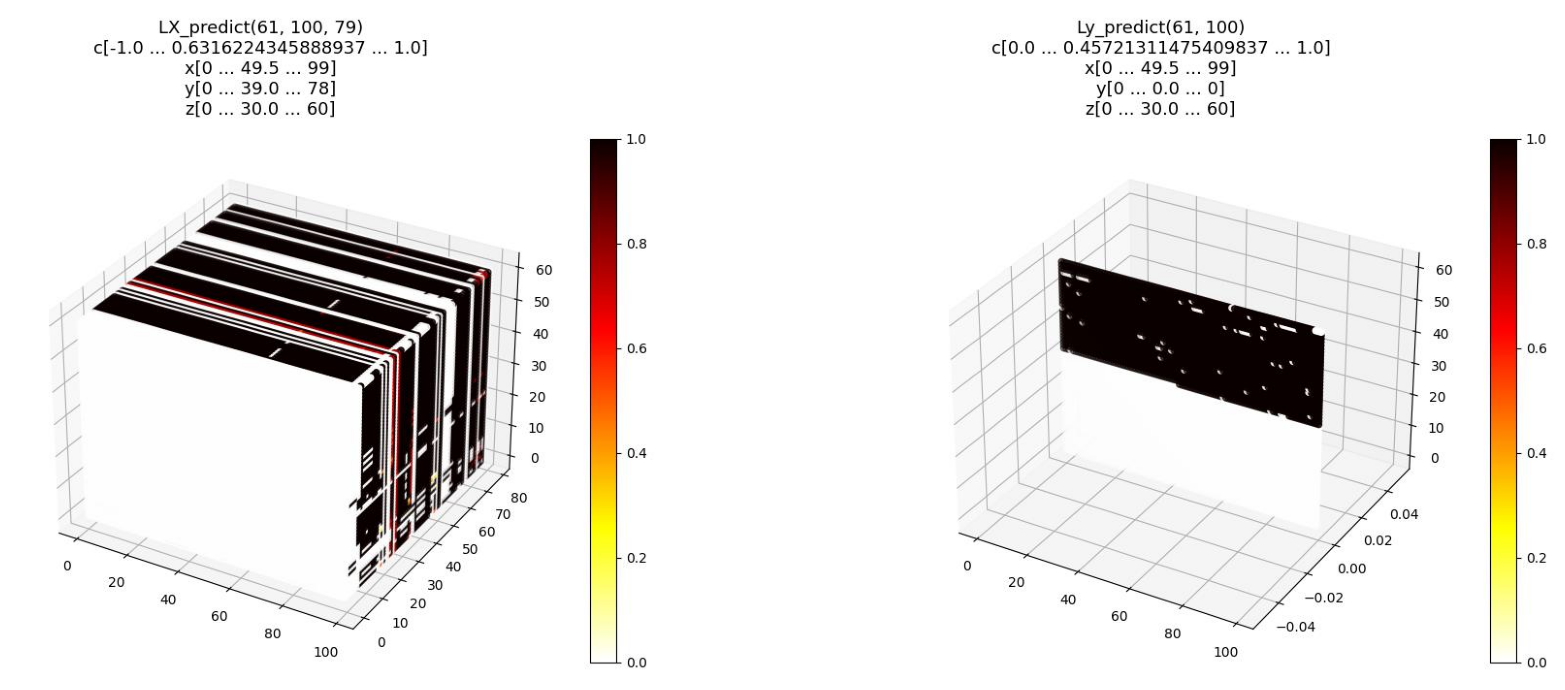

In [12]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [13]:
def threshold(num):
    return 1 if num > 0.5 else 0

def infer(name='model', checkpoint='anomaly_flow79_local_ssh_norm'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    print(f"predicted/Ly_predict = {predicted.sum()}/{Ly_predict.sum()}")
    #np.logical_and(predicted.reshape((56,100)), Ly_predict).sum()

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-02-12 17:02:11.476895: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-02-12 17:02:11.477689: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-02-12 17:02:11.478446: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-02-12 17:02:11.479189: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


predicted/Ly_predict = 2742/2789.0


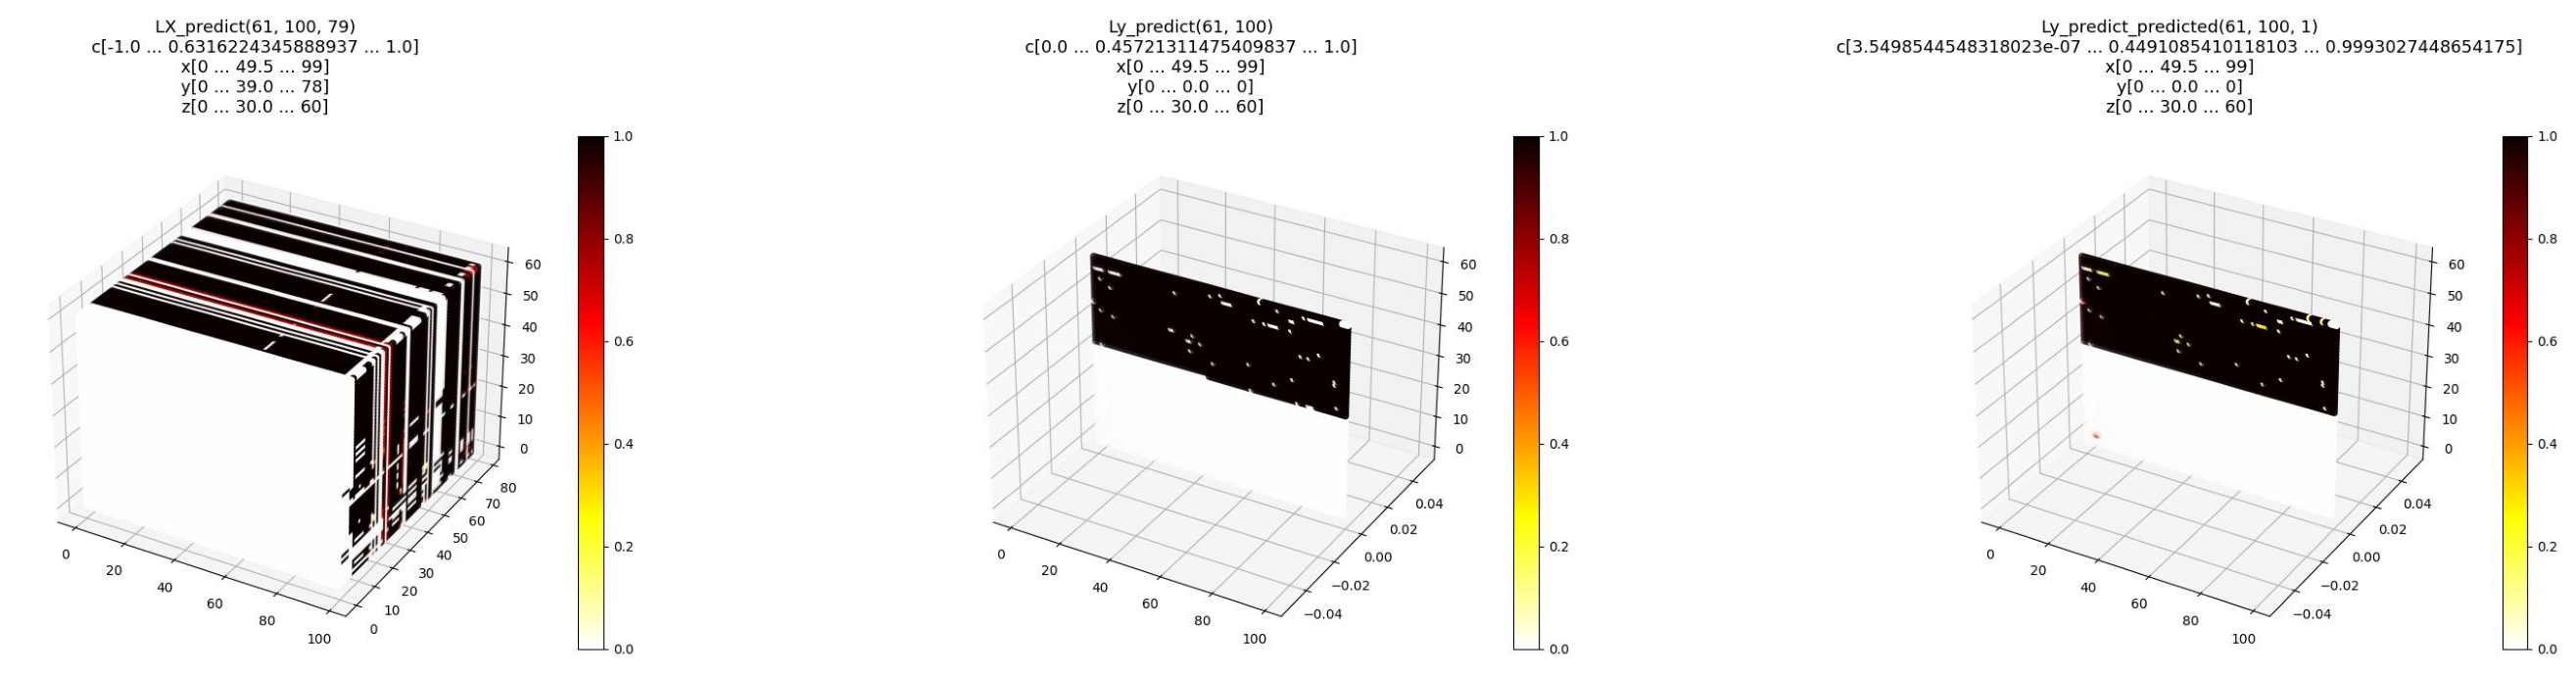

In [14]:
infer('model6', 'anomaly_flow79_local_ssh_norm')

predicted/Ly_predict = 2794/2789.0


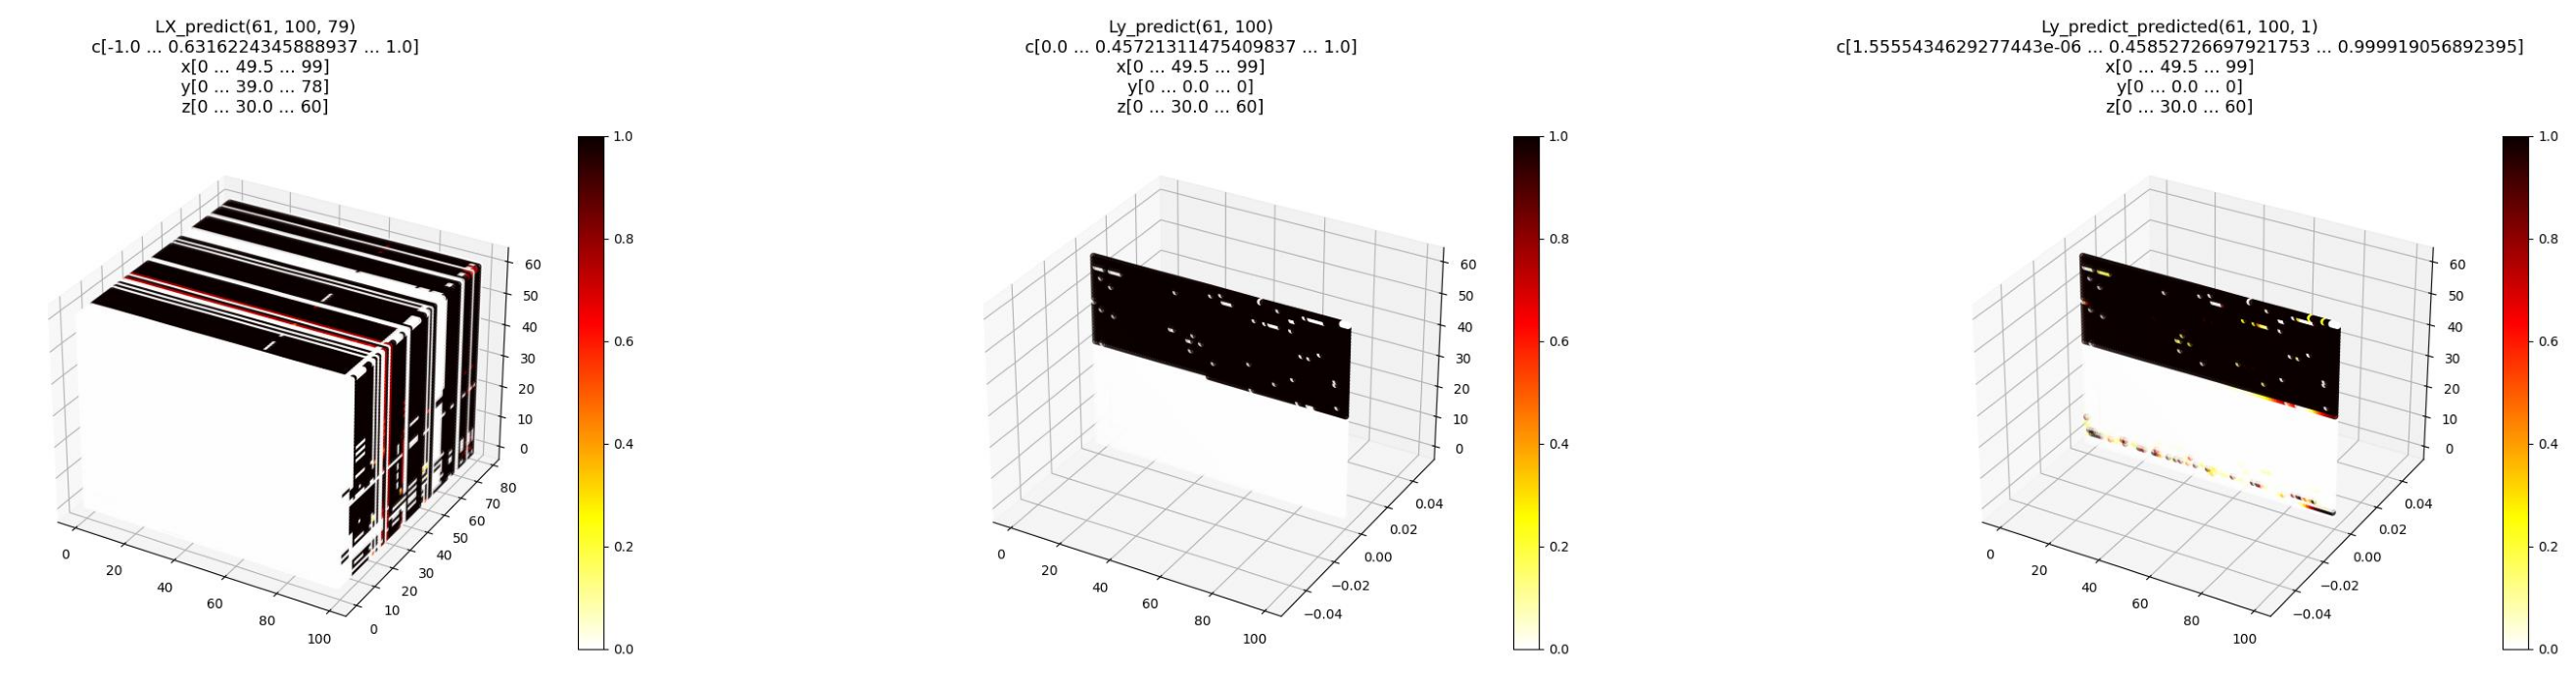

In [15]:
infer('model6', 'anomaly_flow79_local_ftp_transfer_local_ssh_norm')

predicted/Ly_predict = 2835/2789.0


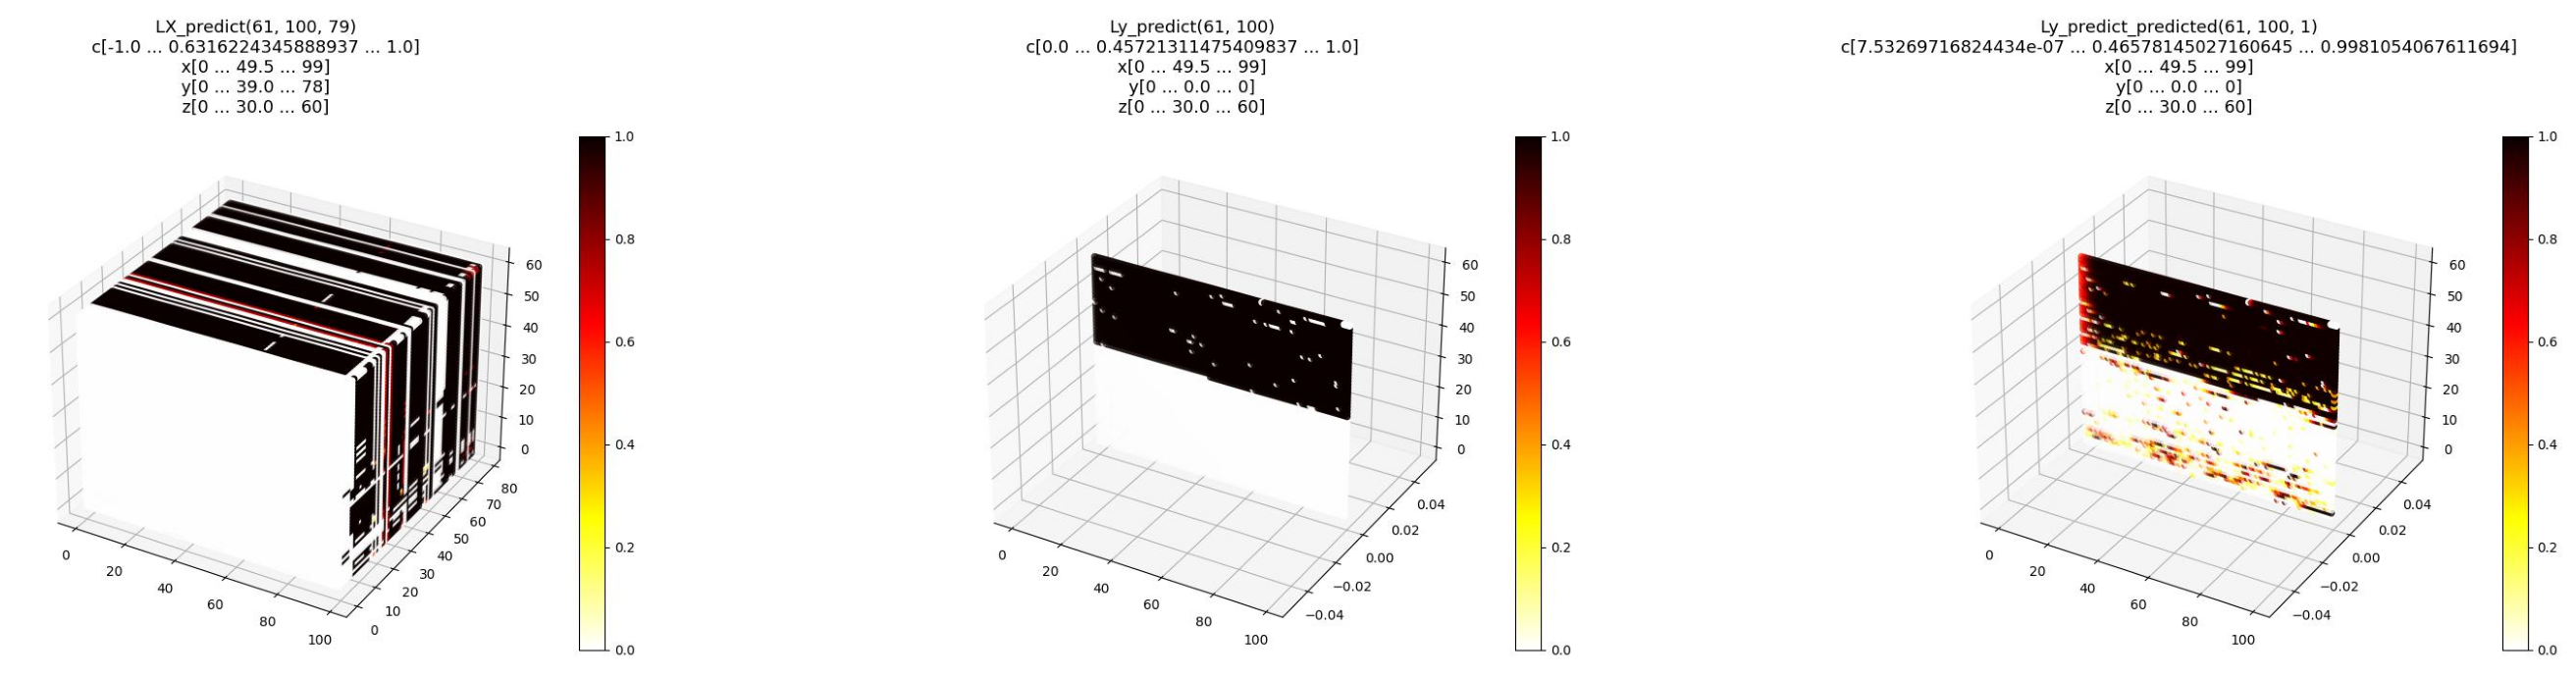

In [16]:
infer('model6', 'anomaly_flow79_local_ssh_transfer_local_ftp_norm')

predicted/Ly_predict = 2756/2789.0


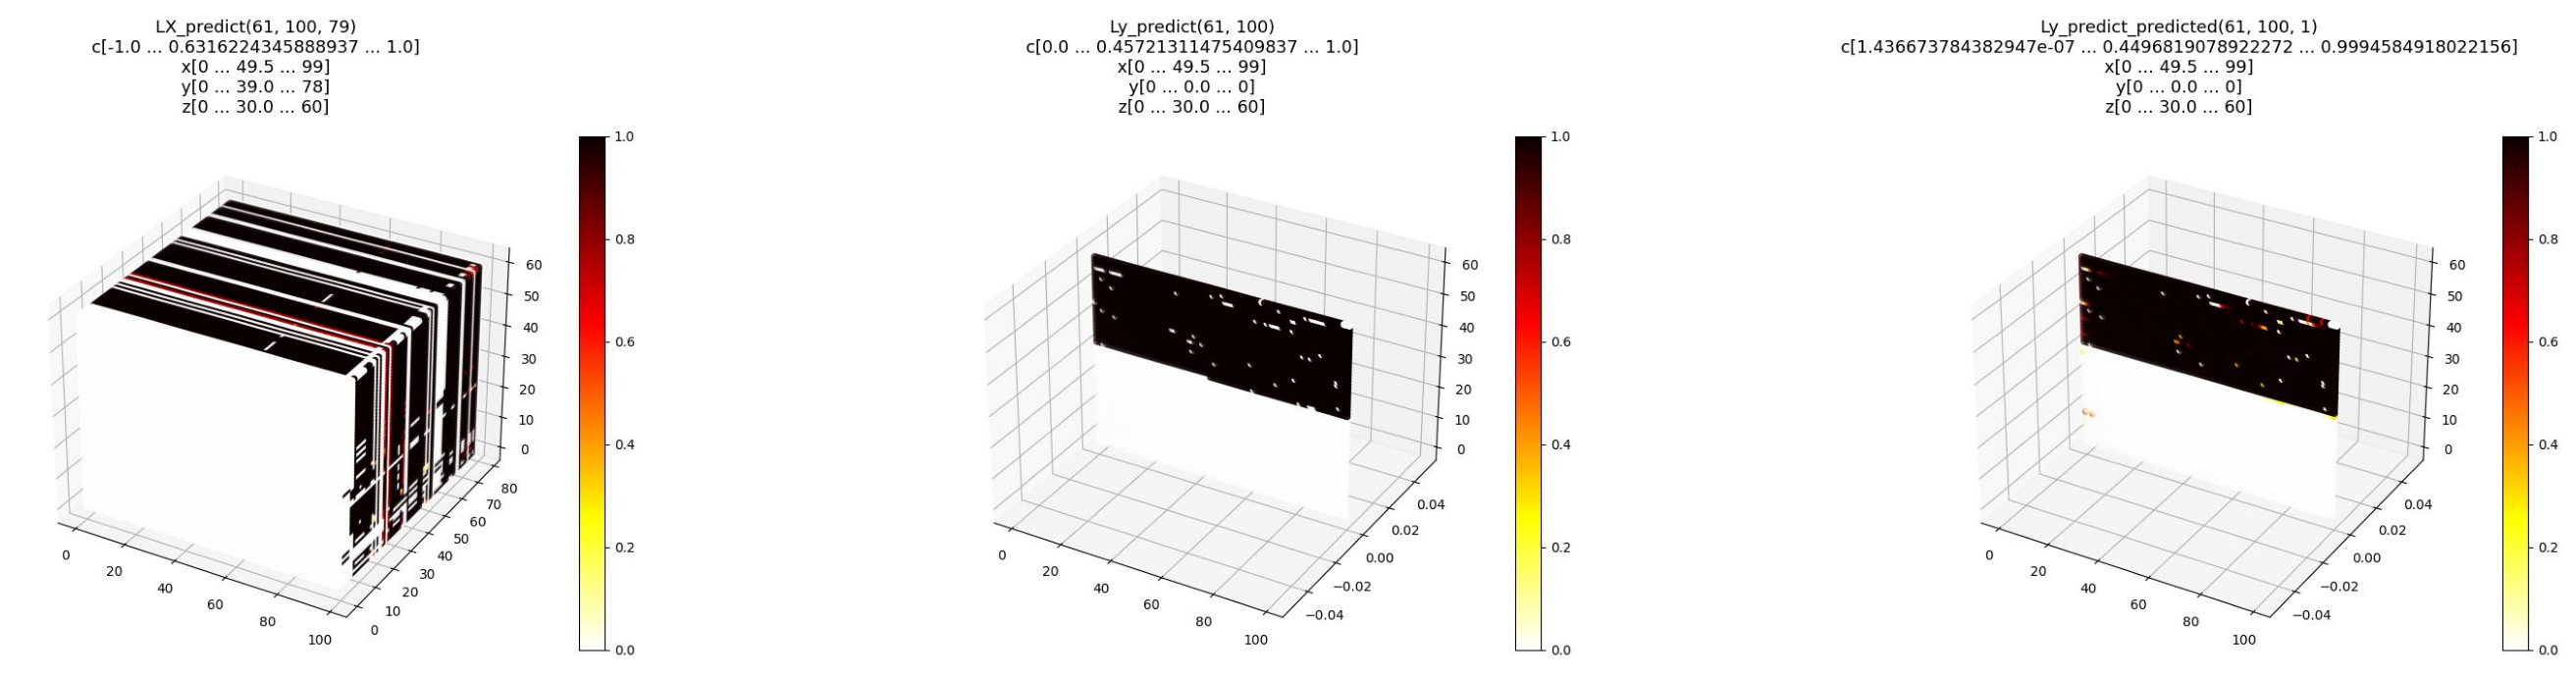

In [17]:
infer('model6', 'anomaly_flow79_local_ftp_ssh_norm')

2023-02-12 17:02:29,193[WARNING][140229732415296-MainThread] def_function.py:called_with_tracing(163) 5 out of the last 9 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f87ec6e8400> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


predicted/Ly_predict = 3/2789.0


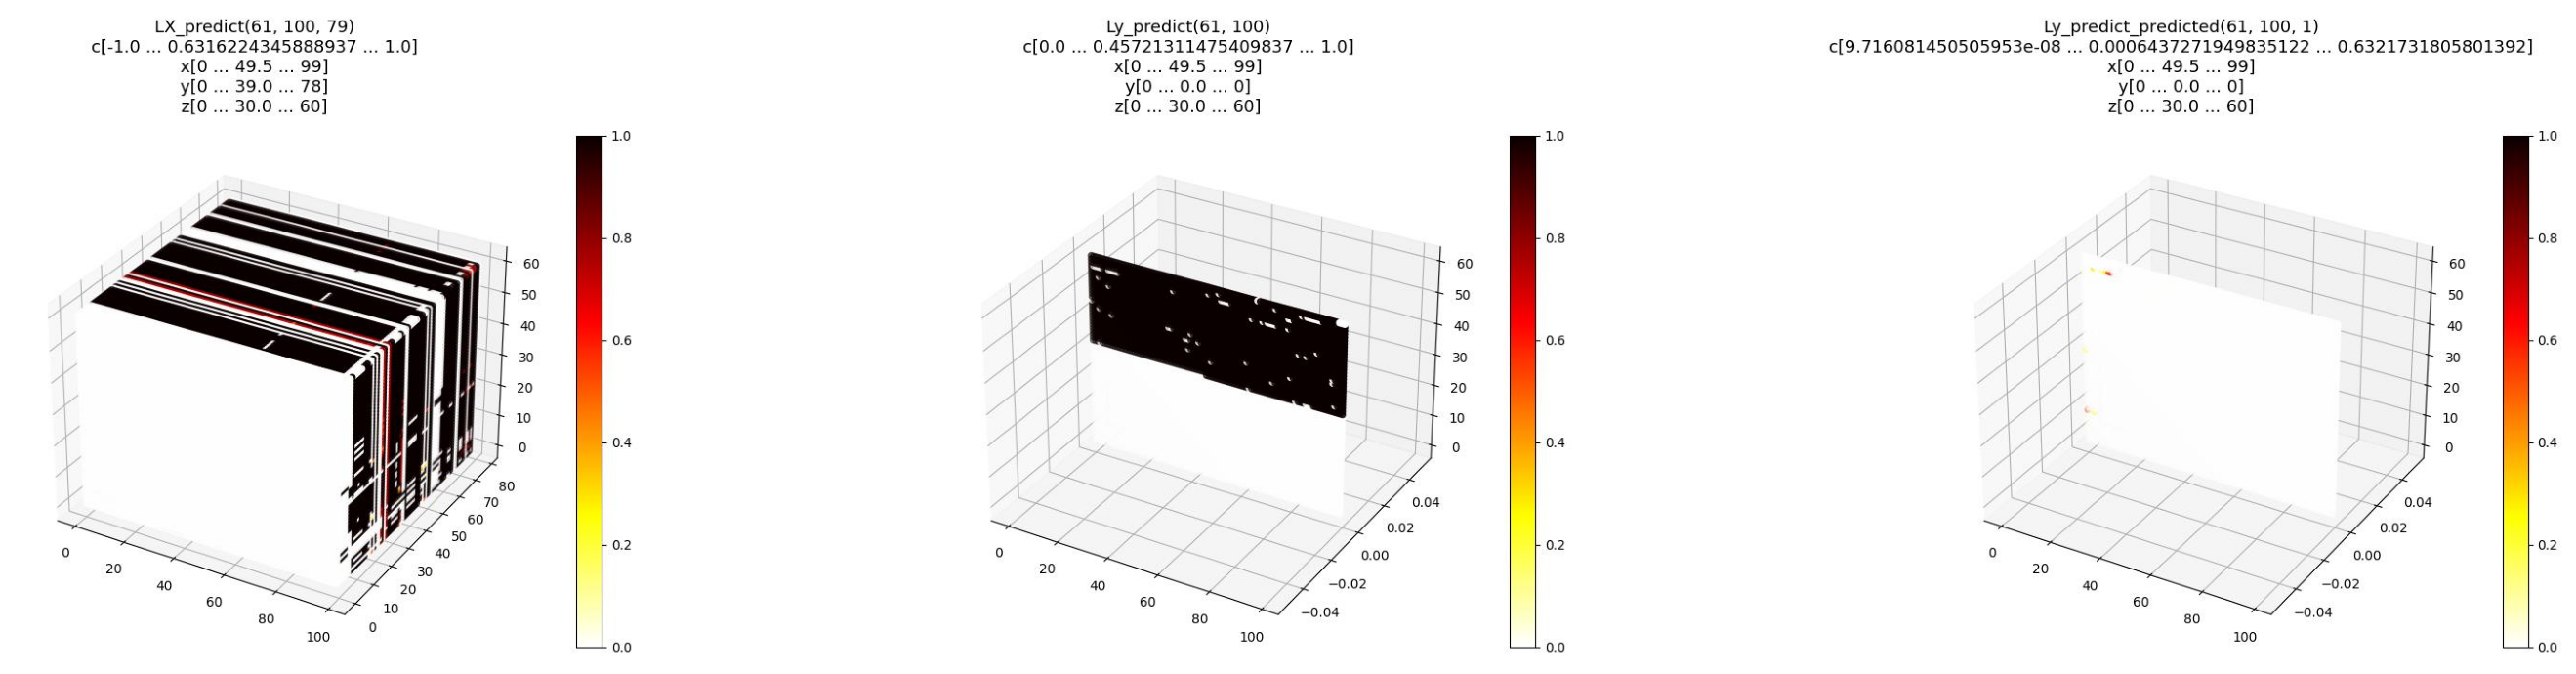

In [18]:
infer('model6', 'anomaly_flow79_local_ftp_norm')

In [19]:
#infer('model6', 'anomaly_flow79_cic_ftp_norm')